Flow Matching from Scratch!

## Setup environment

In [ ]:
# Import essential modules. Feel free to add whatever you need.
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1DxAvlEc4g10bjqk03ExAUAiZznMjyT0k/CS280/HW2


# Part 1: Training a Single-step Denoising UNet


## Implementing Simple and Composed Ops

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.gelu(x)



class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.downconv = nn.Conv2d(in_channels,
                                  out_channels,
                                  kernel_size=3,
                                  stride=2,
                                  padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.downconv(x)
        x = self.bn(x)
        return F.gelu(x)


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv_trans = nn.ConvTranspose2d(in_channels,
                                             out_channels,
                                             kernel_size=4,
                                             stride=2,
                                             padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_trans(x)
        x = self.bn(x)
        return F.gelu(x)


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg_pool = nn.AvgPool2d(7)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.gelu(self.avg_pool(x))


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.conv_trans = nn.ConvTranspose2d(in_channels,
                                             in_channels,
                                             kernel_size=7,
                                             stride=7,
                                             padding=0)
        self.bn = nn.BatchNorm2d(in_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_trans(x)
        x = self.bn(x)
        return F.gelu(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = Conv(in_channels, out_channels)
        self.conv2 = Conv(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        return self.conv2(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.down_conv = DownConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.down_conv(x)
        return self.conv_block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.up_conv = UpConv(in_channels, out_channels)
        self.conv_block = ConvBlock(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.up_conv(x)
        return self.conv_block(x)

## Implementing Unconditional UNet

In [ ]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.conv_block_init = ConvBlock(in_channels, num_hiddens)
        self.down_block_1 = DownBlock(num_hiddens, num_hiddens)
        self.down_block_2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten = Flatten()
        self.unflatten = Unflatten(2*num_hiddens)
        self.upblock1 = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2 = UpBlock(2*num_hiddens, num_hiddens)
        self.conv_block_final = ConvBlock(2*num_hiddens, num_hiddens)
        self.conv_output = nn.Conv2d(num_hiddens,
                                       in_channels,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        down1 = self.conv_block_init(x)
        down2 = self.down_block_1(down1)
        down3 = self.down_block_2(down2)
        bottom = self.flatten(down3)
        up1 = torch.cat((down3, self.unflatten(bottom)), 1)
        up2 = torch.cat((down2, self.upblock1(up1)), 1)
        up3 = torch.cat((down1, self.upblock2(up2)), 1)
        return self.conv_output(self.conv_block_final(up3))

##Using the UNet to Train a Denoiser

Load Data

In [ ]:
batch_size = 256

transform = transforms.Compose([ToTensor()])
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

Visualize Example Noised Data

In [ ]:
def noise_image(img, sigma):
  """ Given img(s) of shape (28, 28), return noised version of img by computing img + sigma * epsilon,
  where epsilon is Gaussian noise of shape (28, 28).
  """
  return img + sigma * torch.randn(size=img.shape)

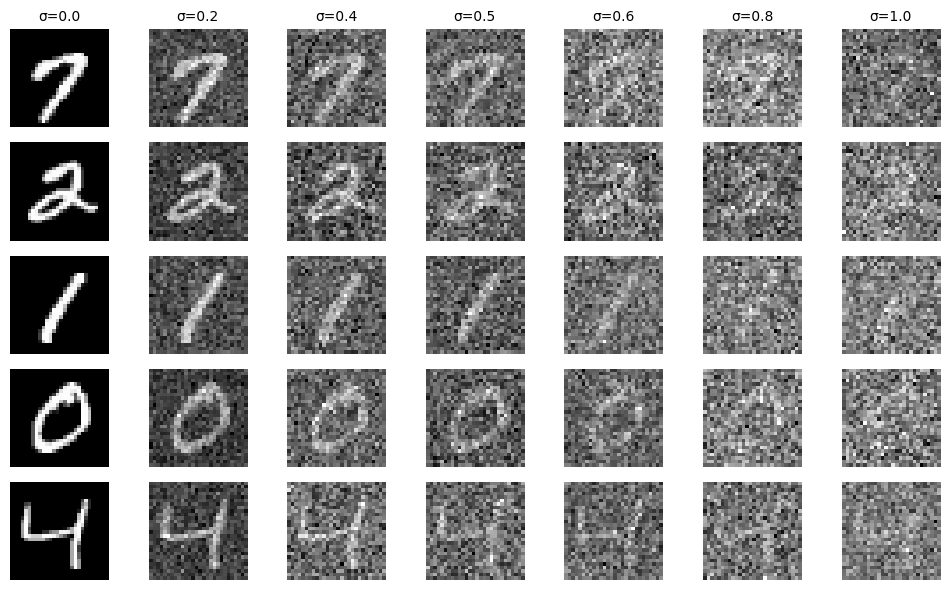

In [ ]:
digits_to_display = [7, 2, 1, 0, 4]
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

ex_images = []
for digit in digits_to_display:
  ind = 0
  while trainset[ind][1] != digit:
    ind += 1
  ex_images.append(trainset[ind][0])


fig, axes = plt.subplots(len(ex_images), len(sigmas), figsize=(10, 6))

for i, img in enumerate(ex_images):
    for j, sigma in enumerate(sigmas):
        noisy_img = noise_image(img, sigma)
        axes[i, j].imshow(noisy_img.numpy().reshape(28,28), cmap="grey")
        axes[i, j].axis('off')
for j, sigma in enumerate(sigmas):
    axes[0, j].set_title(f'σ={sigma}', fontsize=10)

plt.tight_layout()
plt.show()

Train UNet to Denoise Images with $σ=0.5$

In [ ]:
model = UnconditionalUNet(1, 128)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))
    model.to(device)
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")
model.to(device)

GPU is available
Device name: Tesla T4


UnconditionalUNet(
  (conv_block_init): ConvBlock(
    (conv1): Conv(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down_block_1): DownBlock(
    (down_conv): DownConv(
      (downconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block): ConvBlock(
      (conv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3,

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def train_one_epoch(sigma):

    losses = []
    running_loss = 0.

    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        og_imgs, _ = data
        noised_imgs = noise_image(og_imgs, sigma)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        og_imgs = og_imgs.to(device)
        noised_imgs = noised_imgs.to(device)

        # Make predictions for this batch
        outputs = model(noised_imgs)

        # Compute the loss and its gradients
        loss = loss_fn(og_imgs, outputs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        losses.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} avg loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return losses

In [ ]:
epochs=5
sigma=0.5
losses = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    losses.extend(train_one_epoch(sigma))
    model_path = PATH + '/Denoiser/model_{}/Epoch_{}'.format(timestamp, epoch+1)
    os.makedirs(model_path)
    torch.save(model.state_dict(), model_path + '/weights')

EPOCH 1:
  batch 10 avg loss: 0.11705176383256913
  batch 20 avg loss: 0.0558265320956707
  batch 30 avg loss: 0.032655300386250016
  batch 40 avg loss: 0.022558368928730487
  batch 50 avg loss: 0.018444000370800497
  batch 60 avg loss: 0.01695202328264713
  batch 70 avg loss: 0.015673287119716404
  batch 80 avg loss: 0.015133833419531584
  batch 90 avg loss: 0.014831168204545974
  batch 100 avg loss: 0.014363002311438323
  batch 110 avg loss: 0.014088447764515876
  batch 120 avg loss: 0.013851866964250803
  batch 130 avg loss: 0.013717380072921514
  batch 140 avg loss: 0.013414081279188394
  batch 150 avg loss: 0.013213950488716365
  batch 160 avg loss: 0.013272369373589754
  batch 170 avg loss: 0.01293033193796873
  batch 180 avg loss: 0.01291979281231761
  batch 190 avg loss: 0.012789419200271369
  batch 200 avg loss: 0.012781187240034343
  batch 210 avg loss: 0.01249284204095602
  batch 220 avg loss: 0.012363944016397
  batch 230 avg loss: 0.012100502476096153
EPOCH 2:
  batch 10 a

Plot Training Losses

Text(0.5, 1.0, 'Training Losses')

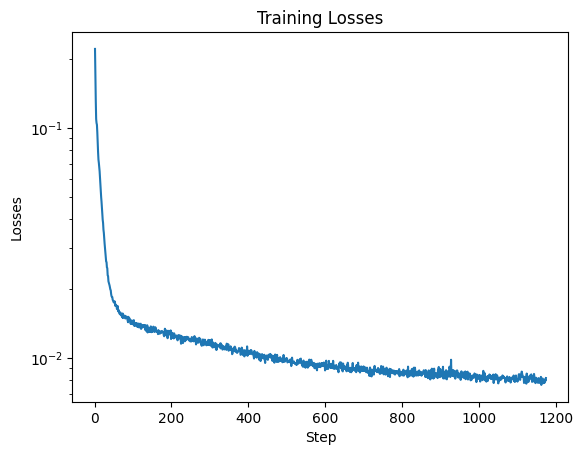

In [ ]:
plt.plot( np.arange(1, len(losses)+1), losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Losses")
plt.title("Training Losses")

Results after 1 epoch of training

In [ ]:
model.load_state_dict(torch.load("Denoiser/model_20250312_035059/Epoch_1/weights", weights_only=True))

<All keys matched successfully>

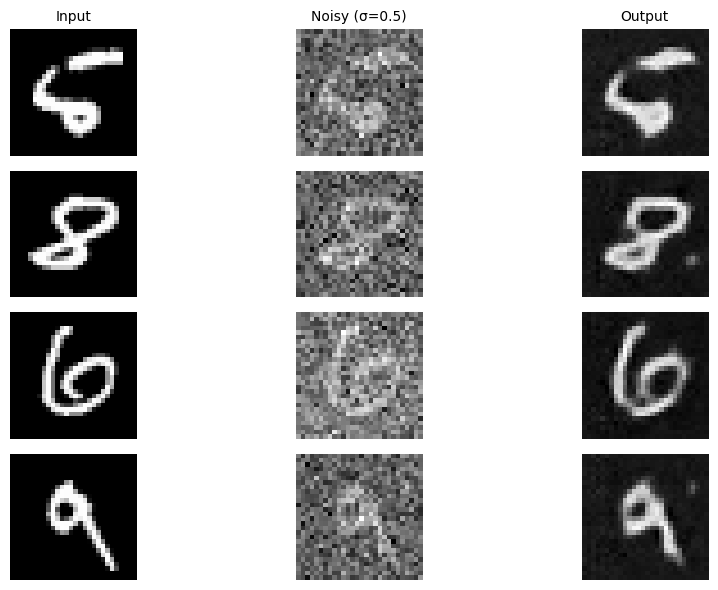

In [ ]:
digits_to_display = [5, 8, 6, 9]

test_images = []
for digit in digits_to_display:
  ind = 0
  while testset[ind][1] != digit:
    ind += 1
  test_images.append(testset[ind][0])


# Noise Images
test_images_noised = [noise_image(img, sigma=0.5) for img in test_images]

# Convert noised images to tensors and move them to the GPU
test_images_noised_torch = torch.tensor(np.array(test_images_noised))
test_images_noised_torch = test_images_noised_torch.to(device)
outputs_torch = model(test_images_noised_torch)

# Move outputs back to CPU and convert them to NumPy arrays
outputs = outputs_torch.detach().cpu().numpy()


fig, axes = plt.subplots(len(test_images), 3, figsize=(10, 6))

for i, img in enumerate(test_images):
      axes[i, 0].imshow(img.numpy().reshape(28,28), cmap="grey")
      axes[i, 0].axis('off')
      axes[i, 1].imshow(test_images_noised[i].numpy().reshape(28,28), cmap="grey")
      axes[i, 1].axis('off')
      axes[i, 2].imshow(outputs[i].reshape(28,28), cmap="grey")
      axes[i, 2].axis('off')

axes[0, 0].set_title("Input", fontsize=10)
axes[0, 1].set_title("Noisy (σ=0.5)", fontsize=10)
axes[0, 2].set_title("Output", fontsize=10)

plt.tight_layout()
plt.show()

Results after 5 epochs of training

In [ ]:
model.load_state_dict(torch.load("Denoiser/model_20250312_035059/Epoch_5/weights", weights_only=True))

<All keys matched successfully>

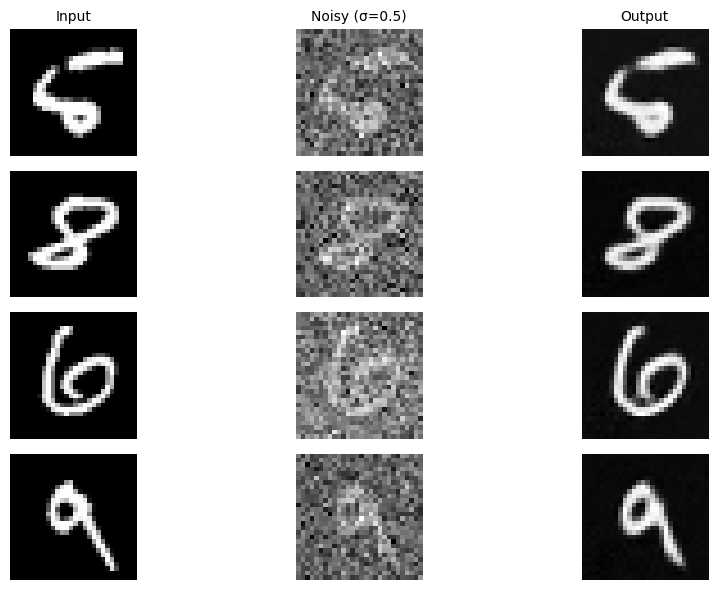

In [ ]:
outputs_torch = model(test_images_noised_torch)

# Move outputs back to CPU and convert them to NumPy arrays
outputs = outputs_torch.detach().cpu().numpy()


fig, axes = plt.subplots(len(test_images), 3, figsize=(10, 6))

for i, img in enumerate(test_images):
      axes[i, 0].imshow(img.numpy().reshape(28,28), cmap="grey")
      axes[i, 0].axis('off')
      axes[i, 1].imshow(test_images_noised[i].numpy().reshape(28,28), cmap="grey")
      axes[i, 1].axis('off')
      axes[i, 2].imshow(outputs[i].reshape(28,28), cmap="grey")
      axes[i, 2].axis('off')

axes[0, 0].set_title("Input", fontsize=10)
axes[0, 1].set_title("Noisy (σ=0.5)", fontsize=10)
axes[0, 2].set_title("Output", fontsize=10)

plt.tight_layout()
plt.show()

Out-of-Distribution Testing

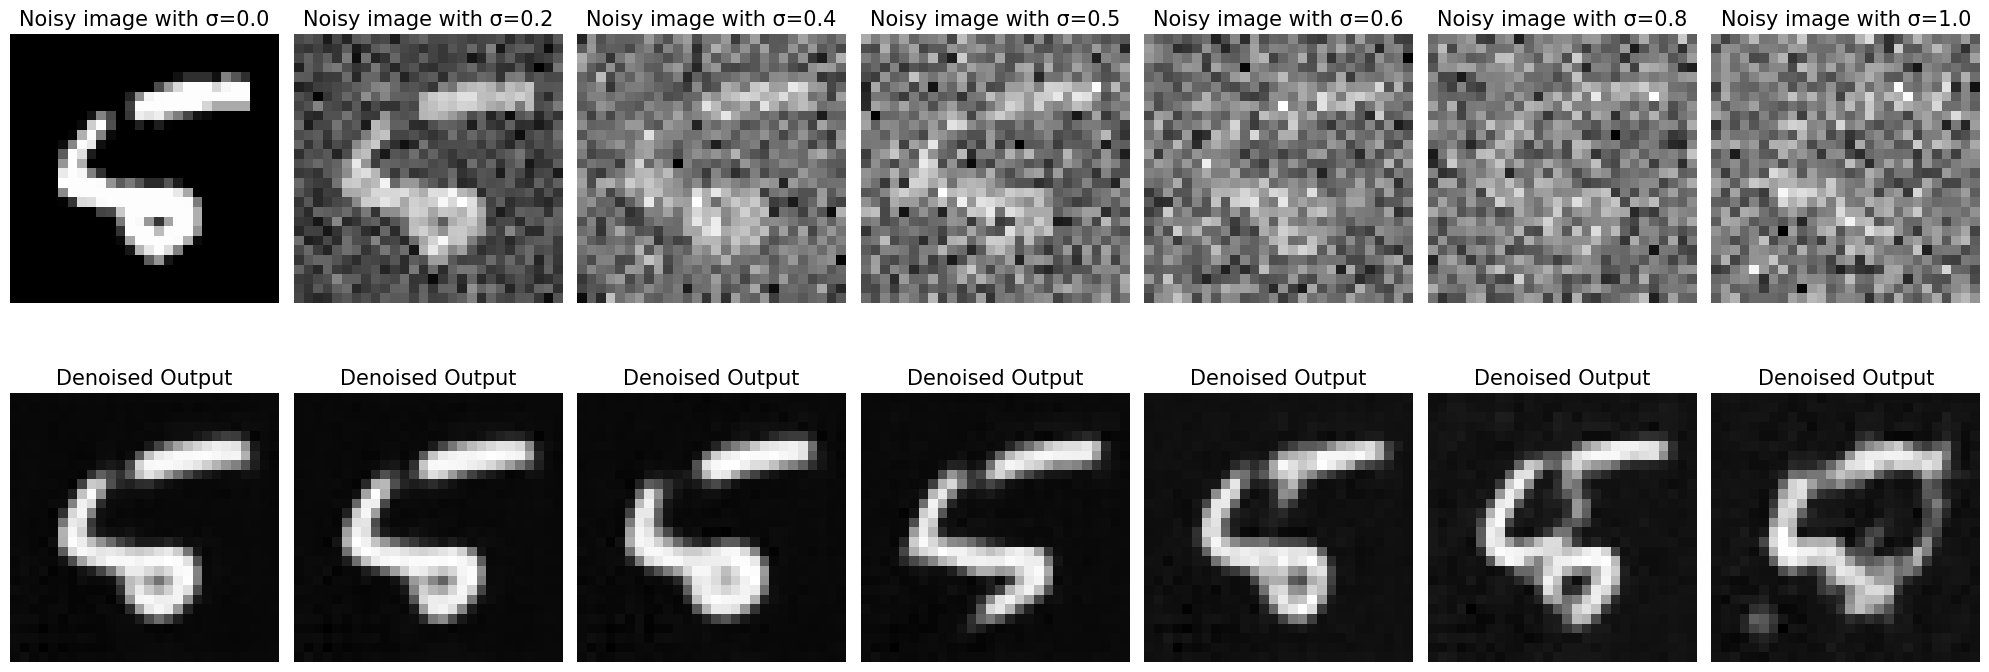

In [ ]:
# Noise Images
sigmas = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]

# Noise Images
test_images_noised = [noise_image(test_images[0], sigma=sigma) for sigma in sigmas]

# Convert noised images to tensors and move them to the GPU
test_images_noised_torch = torch.tensor(np.array(test_images_noised))
test_images_noised_torch = test_images_noised_torch.to(device)
outputs_torch = model(test_images_noised_torch)

# Move outputs back to CPU and convert them to NumPy arrays
outputs = outputs_torch.detach().cpu().numpy()


fig, axes = plt.subplots(2, len(test_images_noised), figsize=(20, 8))

for i, img in enumerate(test_images_noised):
      axes[0, i].imshow(img.numpy().reshape(28,28), cmap="grey")
      axes[0, i].axis('off')
      axes[0, i].set_title(f'Noisy image with σ={sigmas[i]}', fontsize=15)
      axes[1, i].imshow(outputs[i].reshape(28,28), cmap="grey")
      axes[1, i].axis('off')
      axes[1, i].set_title("Denoised Output", fontsize=15)

plt.tight_layout()
plt.show()

Denoising Pure Noise

In [ ]:
model_pure_noise = UnconditionalUNet(1, 128)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")
model_pure_noise.to(device)

GPU is available
Device name: Tesla T4


UnconditionalUNet(
  (conv_block_init): ConvBlock(
    (conv1): Conv(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Conv(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down_block_1): DownBlock(
    (down_conv): DownConv(
      (downconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block): ConvBlock(
      (conv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Conv(
        (conv): Conv2d(128, 128, kernel_size=(3,

In [ ]:
loss_fn_pure_noise = torch.nn.MSELoss()
optimizer_pure_noise = torch.optim.Adam(model_pure_noise.parameters(), lr=1e-4)

In [ ]:
def train_one_epoch_pure_noise():

    losses = []
    running_loss = 0.

    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        og_imgs, _ = data
        pure_noise = torch.randn(size=og_imgs.size())

        # Zero your gradients for every batch!
        optimizer_pure_noise.zero_grad()

        og_imgs = og_imgs.to(device)
        pure_noise = pure_noise.to(device)

        # Make predictions for this batch
        outputs = model_pure_noise(pure_noise)

        # Compute the loss and its gradients
        loss = loss_fn_pure_noise(og_imgs, outputs)
        loss.backward()

        # Adjust learning weights
        optimizer_pure_noise.step()

        # Gather data and report
        losses.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} avg loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return losses

In [ ]:
epochs=5
losses = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    losses.extend(train_one_epoch_pure_noise())
    model_path = PATH + '/PureNoise/model_{}/Epoch_{}'.format(timestamp, epoch+1)
    os.makedirs(model_path)
    torch.save(model.state_dict(), model_path + '/weights')

EPOCH 1:
  batch 10 avg loss: 0.1906114935874939
  batch 20 avg loss: 0.10341801792383194
  batch 30 avg loss: 0.08069271743297576
  batch 40 avg loss: 0.07302152588963509
  batch 50 avg loss: 0.07026462107896805
  batch 60 avg loss: 0.06937843337655067
  batch 70 avg loss: 0.06886186227202415
  batch 80 avg loss: 0.06911361515522003
  batch 90 avg loss: 0.0679245263338089
  batch 100 avg loss: 0.06850175186991692
  batch 110 avg loss: 0.06857549995183945
  batch 120 avg loss: 0.06898285672068596
  batch 130 avg loss: 0.06779423728585243
  batch 140 avg loss: 0.06784619465470314
  batch 150 avg loss: 0.06796754971146583
  batch 160 avg loss: 0.06797438263893127
  batch 170 avg loss: 0.06742284595966339
  batch 180 avg loss: 0.068331228941679
  batch 190 avg loss: 0.06750046536326408
  batch 200 avg loss: 0.06790881901979447
  batch 210 avg loss: 0.06680941209197044
  batch 220 avg loss: 0.0681689091026783
  batch 230 avg loss: 0.06764240935444832
EPOCH 2:
  batch 10 avg loss: 0.0680033

Visualize Model Results

In [ ]:
model_pure_noise.load_state_dict(torch.load("PureNoise/model_20250313_014346/Epoch_5/weights", weights_only=True))

<All keys matched successfully>

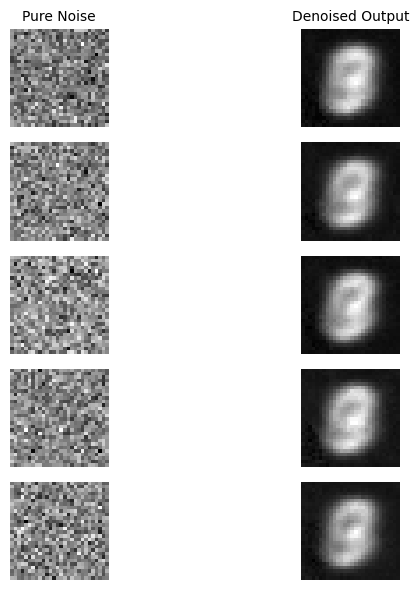

In [ ]:
num_images = 5


# Generate Noise
pure_noise = torch.randn(size=(num_images, 1, 28, 28))

# Convert noised images to tensors and move them to the GPU
pure_noise_gpu = pure_noise.to(device)
outputs = model_pure_noise(pure_noise_gpu)

# Move outputs back to CPU and convert them to NumPy arrays
outputs = outputs.detach().cpu().numpy()


fig, axes = plt.subplots(num_images, 2, figsize=(8, 6))

for i in range(num_images):
      axes[i, 0].imshow(pure_noise[i].numpy().reshape(28,28), cmap="grey")
      axes[i, 0].axis('off')
      axes[i, 1].imshow(outputs[i].reshape(28,28), cmap="grey")
      axes[i, 1].axis('off')

axes[0, 0].set_title("Pure Noise", fontsize=10)
axes[0, 1].set_title("Denoised Output", fontsize=10)


plt.tight_layout()
plt.show()

Visualize Average Image of Training Set

In [ ]:
avg_img = np.mean([item[0] for item in trainset], axis=0)

Text(0.5, 1.0, 'Average Image of Training Set')

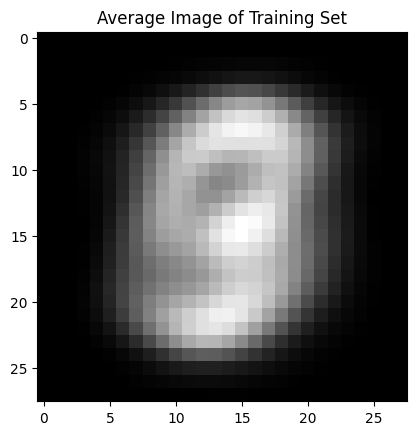

In [ ]:
plt.imshow(avg_img.reshape(28,28), cmap="grey")
plt.title("Average Image of Training Set")

Since pure noise by definition has no signal in it (i.e. contains no information about what digit the noise will be linked to), the best the unconditional UNet can do to minize the MSE training loss is to transform the noise to the average image of the training set. This is confirmed by the results displayed above.

# Part 2: Flow Matching

## Implementing a Time-conditioned UNet

In [ ]:
class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.Linear1 = nn.Linear(in_channels, out_channels)
        self.Linear2 = nn.Linear(out_channels, out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if len(x.shape) == 1:
          x = x.view(*x.shape, 1)
        x = F.gelu(self.Linear1(x))
        x = self.Linear2(x)
        x = x.view(*x.shape, 1, 1)
        return x


class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.conv_block_init = ConvBlock(in_channels, num_hiddens)
        self.down_block_1 = DownBlock(num_hiddens, num_hiddens)
        self.down_block_2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten = Flatten()
        self.unflatten = Unflatten(2*num_hiddens)
        self.upblock1 = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2 = UpBlock(2*num_hiddens, num_hiddens)
        self.conv_block_final = ConvBlock(2*num_hiddens, num_hiddens)
        self.conv_output = nn.Conv2d(num_hiddens,
                                       in_channels,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)
        self.fcblock1 = FCBlock(in_channels=1, out_channels=2*num_hiddens)
        self.fcblock2 = FCBlock(in_channels=1, out_channels=num_hiddens)

    def forward(
        self,
        x: torch.Tensor,
        t: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            t: (N,) normalized time tensor.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        down1 = self.conv_block_init(x)
        down2 = self.down_block_1(down1)
        down3 = self.down_block_2(down2)
        bottom = self.flatten(down3)
        up1 = torch.cat((down3, self.unflatten(bottom) * self.fcblock1(t)), 1)
        up2 = torch.cat((down2, self.upblock1(up1) * self.fcblock2(t)), 1)
        up3 = torch.cat((down1, self.upblock2(up2)), 1)
        return self.conv_output(self.conv_block_final(up3))


## Implementing the Forward and Reverse Process for Time-conditioned Denoising

In [ ]:
def fm_forward(
    unet: TimeConditionalUNet,
    x_1: torch.Tensor
) -> torch.Tensor:
    """Algorithm 1

    Args:
        unet: TimeConditionalUNet
        x_1: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) loss.
    """
    unet.train()
    x_0 = torch.randn_like(x_1)
    x_0 = x_0.to(device)
    target = x_1 - x_0
    t = torch.rand((x_0.shape[0],))
    t = t.to(device)
    t_sample = t.view(*t.shape, 1, 1, 1)
    x_t = x_0 + t_sample*(x_1 - x_0)
    output = unet(x_t, t)
    return ((target - output)**2).mean()

In [ ]:
@torch.inference_mode()
def fm_sample(
    unet: TimeConditionalUNet,
    img_wh: tuple[int, int],
    num_ts: int,
    num_samples: int,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 2

    Args:
        unet: TimeConditionalUNet
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
    """
    unet.eval()
    x_t = torch.randn((num_samples, 1, img_wh[0], img_wh[1]))
    x_t = x_t.to(device)
    step_size = 1 / num_ts
    t = torch.zeros((num_samples,))
    t = t.to(device)
    while t[0].item() < 1:
      x_t = x_t + step_size * unet(x_t, t)
      t += step_size
    return x_t

In [ ]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        num_ts: int = 50,
        img_hw: tuple[int, int] = (28, 28),
    ):
        super().__init__()

        self.unet = unet
        self.num_ts = num_ts
        self.img_hw = img_hw


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) flow matching loss.
        """
        return fm_forward(
            self.unet, x
        )


    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        num_samples,
        seed: int = 0,
    ):
        return fm_sample(
            self.unet, img_wh, self.num_ts, num_samples, seed
        )


Train Time-Conditioned U-Net

In [ ]:
batch_size = 64

transform = transforms.Compose([ToTensor()])
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
time_cond_unet = TimeConditionalUNet(1, 64)
flow_matching_model = FlowMatching(time_cond_unet)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")
flow_matching_model.to(device)

GPU is available
Device name: Tesla T4


FlowMatching(
  (unet): TimeConditionalUNet(
    (conv_block_init): ConvBlock(
      (conv1): Conv(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (down_block_1): DownBlock(
      (down_conv): DownConv(
        (downconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block): ConvBlock(
        (conv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv2

In [ ]:
num_epochs = 20
optimizer = torch.optim.Adam(flow_matching_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/num_epochs))

In [ ]:
def train_one_epoch():

    losses = []
    running_loss = 0.

    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        og_imgs, _ = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        og_imgs = og_imgs.to(device)

        # Get flow matching loss for batch
        loss = flow_matching_model(og_imgs)

        # Compute gradients
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        losses.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} avg loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return losses

In [ ]:
losses = []
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(num_epochs):
    print('EPOCH {}:'.format(epoch + 1))

    # Do a pass over the data
    losses.extend(train_one_epoch())
    scheduler.step() # decay learning rate
    model_path = PATH + '/TimeCondFlowMatching/model_{}/Epoch_{}'.format(timestamp, epoch+1)
    os.makedirs(model_path)
    torch.save(flow_matching_model.state_dict(), model_path + '/weights')

EPOCH 1:
  batch 10 avg loss: 1.3399965405464171
  batch 20 avg loss: 0.4772588282823563
  batch 30 avg loss: 0.3418890178203583
  batch 40 avg loss: 0.3009112775325775
  batch 50 avg loss: 0.27837195694446565
  batch 60 avg loss: 0.26514526307582853
  batch 70 avg loss: 0.2594445064663887
  batch 80 avg loss: 0.2312612920999527
  batch 90 avg loss: 0.2213256612420082
  batch 100 avg loss: 0.21787734031677247
  batch 110 avg loss: 0.2051524832844734
  batch 120 avg loss: 0.20225581377744675
  batch 130 avg loss: 0.19390323162078857
  batch 140 avg loss: 0.1959615409374237
  batch 150 avg loss: 0.19056452959775924
  batch 160 avg loss: 0.18257888406515121
  batch 170 avg loss: 0.19182671904563903
  batch 180 avg loss: 0.19087214916944503
  batch 190 avg loss: 0.16845132857561113
  batch 200 avg loss: 0.16663928180933
  batch 210 avg loss: 0.1737750217318535
  batch 220 avg loss: 0.16273928433656693
  batch 230 avg loss: 0.15840454399585724
  batch 240 avg loss: 0.17499644160270691
  bat

Text(0.5, 1.0, 'Training Losses')

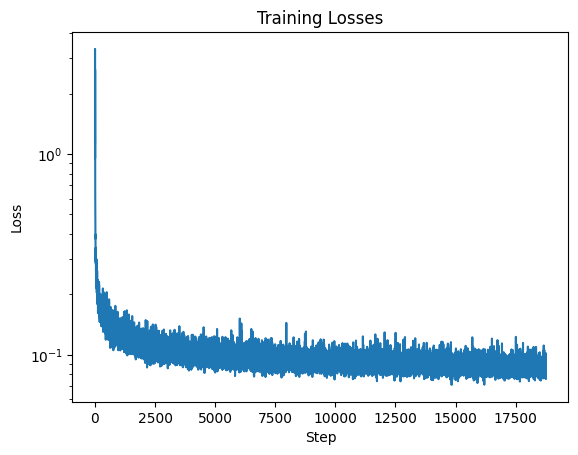

In [ ]:
plt.plot(np.arange(1, len(losses)+1), losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Losses")

Visualize Results from Epoch 5

In [ ]:
flow_matching_model.load_state_dict(torch.load("TimeCondFlowMatching/model_20250316_210349/Epoch_5/weights", weights_only=True))

<All keys matched successfully>

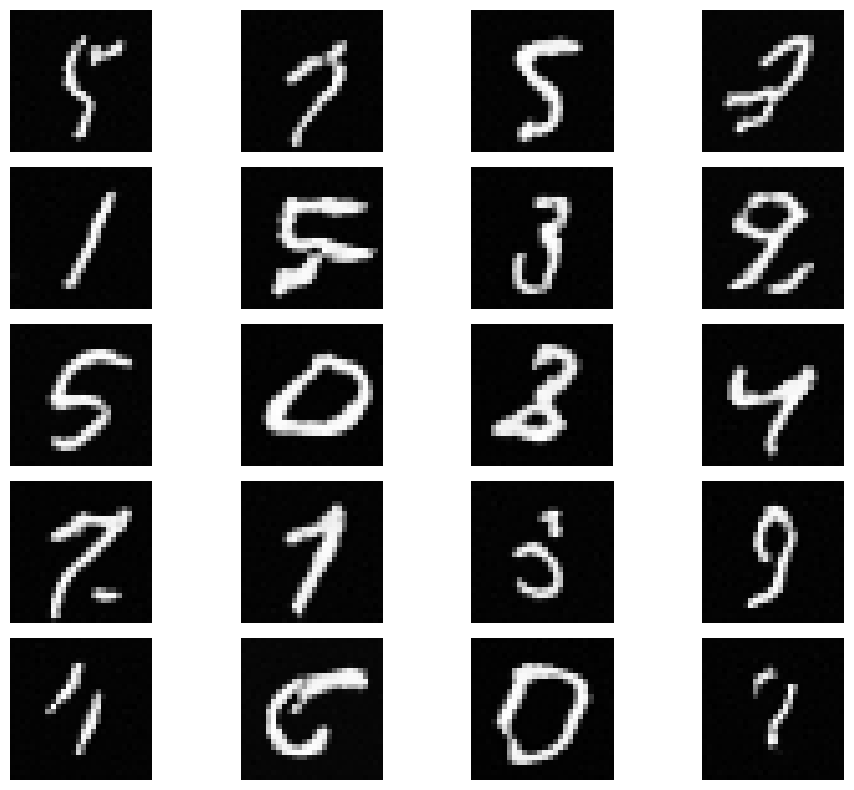

In [ ]:
num_samples = 20

# Generate Noise
samples = flow_matching_model.sample((28,28), num_samples=num_samples)

# Move outputs back to CPU and convert them to NumPy arrays
samples_cpu = samples.detach().cpu().numpy()


fig, axes = plt.subplots(5, 4, figsize=(10, 8))

for i in range(5):
  for j in range(4):
      axes[i, j].imshow(samples_cpu[4*i+j].reshape(28,28), cmap="grey")
      axes[i, j].axis('off')


plt.tight_layout()
plt.show()

Visualize Results from Epoch 10

In [ ]:
flow_matching_model.load_state_dict(torch.load("TimeCondFlowMatching/model_20250316_210349/Epoch_10/weights", weights_only=True))

<All keys matched successfully>

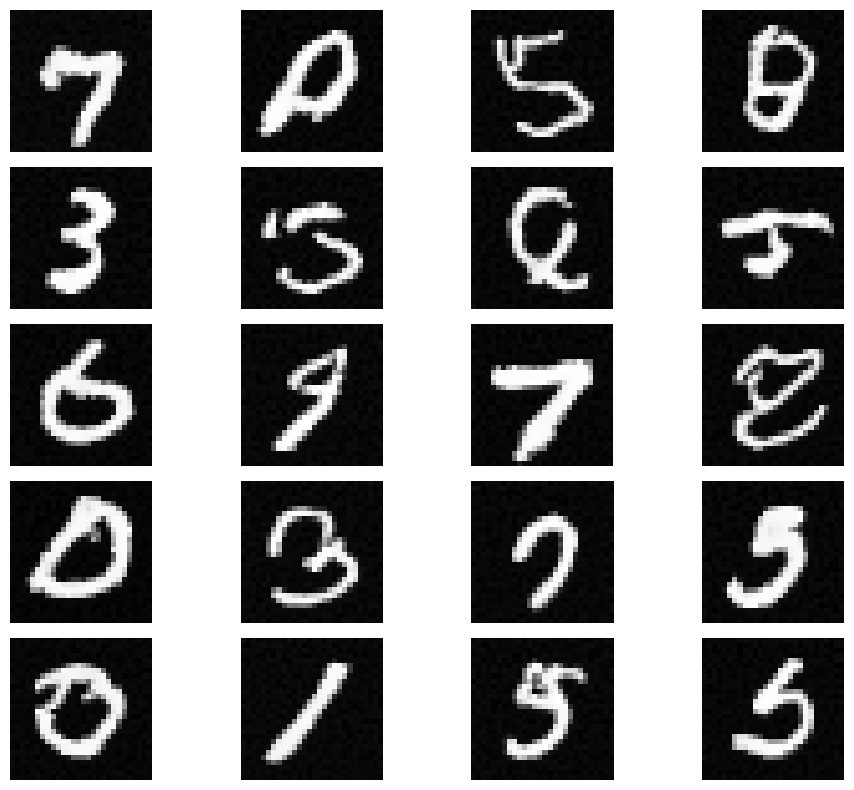

In [ ]:
num_samples = 20

# Generate Noise
samples = flow_matching_model.sample((28,28), num_samples=num_samples)

# Move outputs back to CPU and convert them to NumPy arrays
samples_cpu = samples.detach().cpu().numpy()


fig, axes = plt.subplots(5, 4, figsize=(10, 8))

for i in range(5):
  for j in range(4):
      axes[i, j].imshow(samples_cpu[4*i+j].reshape(28,28), cmap="grey")
      axes[i, j].axis('off')


plt.tight_layout()
plt.show()

### Implementing class-conditioned UNet

In [ ]:
class ClassConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        num_hiddens: int,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.conv_block_init = ConvBlock(in_channels, num_hiddens)
        self.down_block_1 = DownBlock(num_hiddens, num_hiddens)
        self.down_block_2 = DownBlock(num_hiddens, 2*num_hiddens)
        self.flatten = Flatten()
        self.unflatten = Unflatten(2*num_hiddens)
        self.upblock1 = UpBlock(4*num_hiddens, num_hiddens)
        self.upblock2 = UpBlock(2*num_hiddens, num_hiddens)
        self.conv_block_final = ConvBlock(2*num_hiddens, num_hiddens)
        self.conv_output = nn.Conv2d(num_hiddens,
                                       in_channels,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)
        self.fcblockt1 = FCBlock(in_channels=1, out_channels=2*num_hiddens)
        self.fcblockc1 = FCBlock(in_channels=num_classes, out_channels=2*num_hiddens)
        self.fcblockt2 = FCBlock(in_channels=1, out_channels=num_hiddens)
        self.fcblockc2 = FCBlock(in_channels=num_classes, out_channels=num_hiddens)


    def forward(
        self,
        x: torch.Tensor,
        c: torch.Tensor,
        t: torch.Tensor,
        mask:torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.
            t: (N,) normalized time tensor.
            mask: (N,) mask tensor. If not None, mask out condition when mask == 0.

        Returns:
            (N, C, H, W) output tensor.
        """
        assert x.shape[-2:] == (28, 28), "Expect input shape to be (28, 28)."
        down1 = self.conv_block_init(x)
        down2 = self.down_block_1(down1)
        down3 = self.down_block_2(down2)
        bottom = self.flatten(down3)
        c_onehot = F.one_hot(c, num_classes=self.num_classes) * mask.view(*mask.shape, 1)
        up1 = torch.cat((down3, self.unflatten(bottom) * self.fcblockc1(c_onehot) + self.fcblockt1(t)), 1)
        up2 = torch.cat((down2, self.upblock1(up1) * self.fcblockc2(c_onehot) + self.fcblockt2(t)), 1)
        up3 = torch.cat((down1, self.upblock2(up2)), 1)
        return self.conv_output(self.conv_block_final(up3))

In [ ]:
def fm_forward(
    unet: ClassConditionalUNet,
    x_1: torch.Tensor,
    c: torch.Tensor,
    p_uncond: float,
    num_ts: int,
) -> torch.Tensor:
    """Algorithm 3

    Args:
        unet: ClassConditionalUNet
        x_1: (N, C, H, W) input tensor.
        c: (N,) int64 condition tensor.
        p_uncond: float, probability of unconditioning the condition.
        num_ts: int, number of timesteps.

    Returns:
        (,) loss.
    """
    unet.train()
    x_0 = torch.randn_like(x_1)
    x_0 = x_0.to(device)
    target = x_1 - x_0
    t = torch.rand((x_0.shape[0],))
    t = t.to(device)
    t_sample = t.view(*t.shape, 1, 1, 1)
    x_t = x_0 + t_sample*(x_1 - x_0)
    mask = torch.bernoulli((1-p_uncond) * torch.ones((c.shape[0],)))
    mask = mask.to(device)
    output = unet(x_t, c, t, mask)
    return ((target - output)**2).mean()

In [ ]:
@torch.inference_mode()
def fm_sample(
    unet: ClassConditionalUNet,
    c: torch.Tensor,
    img_wh: tuple[int, int],
    num_ts: int,
    num_samples: int,
    guidance_scale: float = 5.0,
    seed: int = 0,
) -> torch.Tensor:
    """Algorithm 4

    Args:
        unet: ClassConditionalUNet
        c: (N,) int64 condition tensor. Only for class-conditional
        img_wh: (H, W) output image width and height.
        num_ts: int, number of timesteps.
        num_samples: number of sample to draw at once
        guidance_scale: float, CFG scale.
        seed: int, random seed.

    Returns:
        (N, C, H, W) final sample.
        (N, T_animation, C, H, W) caches.
    """
    unet.eval()
    x_t = torch.randn((num_samples, 1, img_wh[0], img_wh[1]))
    x_t = x_t.to(device)
    step_size = 1 / num_ts
    t = torch.zeros((num_samples,))
    t = t.to(device)
    c = c.to(device)
    while t[0].item() < 1:
      mask_uncond = torch.zeros((c.shape[0],)).to(device)
      mask_cond = torch.ones((c.shape[0],)).to(device)
      u_uncond = unet(x_t, c, t, mask_uncond)
      u_cond = unet(x_t, c, t, mask_cond)
      u = u_uncond + guidance_scale * (u_cond - u_uncond)
      x_t = x_t + step_size * u
      t += step_size
    return x_t

In [ ]:
class FlowMatching(nn.Module):
    def __init__(
        self,
        unet: ClassConditionalUNet,
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.num_ts = num_ts
        self.p_uncond = p_uncond

    def forward(self, x: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.
            c: (N,) int64 condition tensor.

        Returns:
            (,) loss.
        """
        return fm_forward(
            self.unet, x, c, self.p_uncond, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        c: torch.Tensor,
        img_wh: tuple[int, int],
        num_samples: int,
        guidance_scale: float = 5.0,
        seed: int = 0,
    ):
        return fm_sample(
            self.unet, c, img_wh, self.num_ts, num_samples, guidance_scale, seed
        )

In [ ]:
class_cond_unet = ClassConditionalUNet(1, 10, 64)
class_flow_matching_model = FlowMatching(class_cond_unet)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")
class_flow_matching_model.to(device)

GPU is available
Device name: Tesla T4


FlowMatching(
  (unet): ClassConditionalUNet(
    (conv_block_init): ConvBlock(
      (conv1): Conv(
        (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv2): Conv(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (down_block_1): DownBlock(
      (down_conv): DownConv(
        (downconv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block): ConvBlock(
        (conv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv

In [ ]:
num_epochs = 10
optimizer = torch.optim.Adam(class_flow_matching_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**(1/num_epochs))

In [ ]:
def train_one_epoch_class():

    losses = []
    running_loss = 0.

    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        og_imgs, classes = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        og_imgs = og_imgs.to(device)
        classes = classes.to(device)

        # Get flow matching loss for batch
        loss = class_flow_matching_model(og_imgs, classes)

        # Compute gradients
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        losses.append(loss.item())
        running_loss += loss.item()

        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} avg loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return losses

In [ ]:
losses = []
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

for epoch in range(num_epochs):
    print('EPOCH {}:'.format(epoch + 1))

    # Do a pass over the data
    losses.extend(train_one_epoch_class())
    scheduler.step() # decay learning rate
    model_path = PATH + '/ClassCondFlowMatching/model_{}/Epoch_{}'.format(timestamp, epoch+1)
    os.makedirs(model_path)
    torch.save(class_flow_matching_model.state_dict(), model_path + '/weights')

EPOCH 1:
  batch 10 avg loss: 1.1707277119159698
  batch 20 avg loss: 0.4567102462053299
  batch 30 avg loss: 0.32977125942707064
  batch 40 avg loss: 0.3118279308080673
  batch 50 avg loss: 0.29277640879154204
  batch 60 avg loss: 0.2724431097507477
  batch 70 avg loss: 0.2539568662643433
  batch 80 avg loss: 0.2366749346256256
  batch 90 avg loss: 0.22315507233142853
  batch 100 avg loss: 0.2149449348449707
  batch 110 avg loss: 0.20781663209199905
  batch 120 avg loss: 0.19220853149890899
  batch 130 avg loss: 0.18797448575496672
  batch 140 avg loss: 0.18900682628154755
  batch 150 avg loss: 0.17233670502901077
  batch 160 avg loss: 0.1713165745139122
  batch 170 avg loss: 0.17648808062076568
  batch 180 avg loss: 0.16975656747817994
  batch 190 avg loss: 0.16244233697652816
  batch 200 avg loss: 0.16903683245182038
  batch 210 avg loss: 0.1609428882598877
  batch 220 avg loss: 0.1616462677717209
  batch 230 avg loss: 0.15839844942092896
  batch 240 avg loss: 0.15390039831399918
  

Text(0.5, 1.0, 'Training Losses')

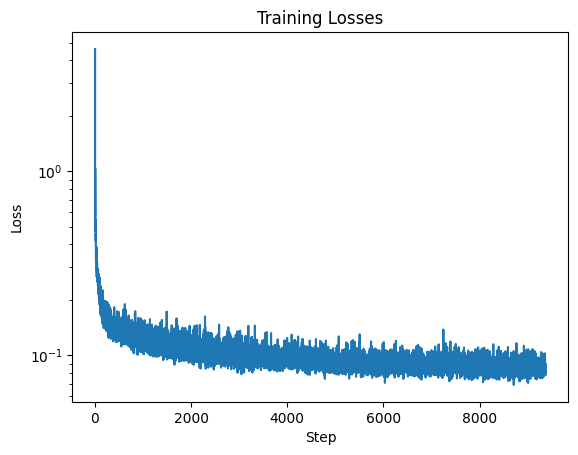

In [ ]:
plt.plot(np.arange(1, len(losses)+1), losses)
plt.yscale("log")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Losses")

Draw Samples From 5th Epoch

In [ ]:
class_flow_matching_model.load_state_dict(torch.load("ClassCondFlowMatching/model_20250317_232224/Epoch_5/weights", weights_only=True))

<All keys matched successfully>

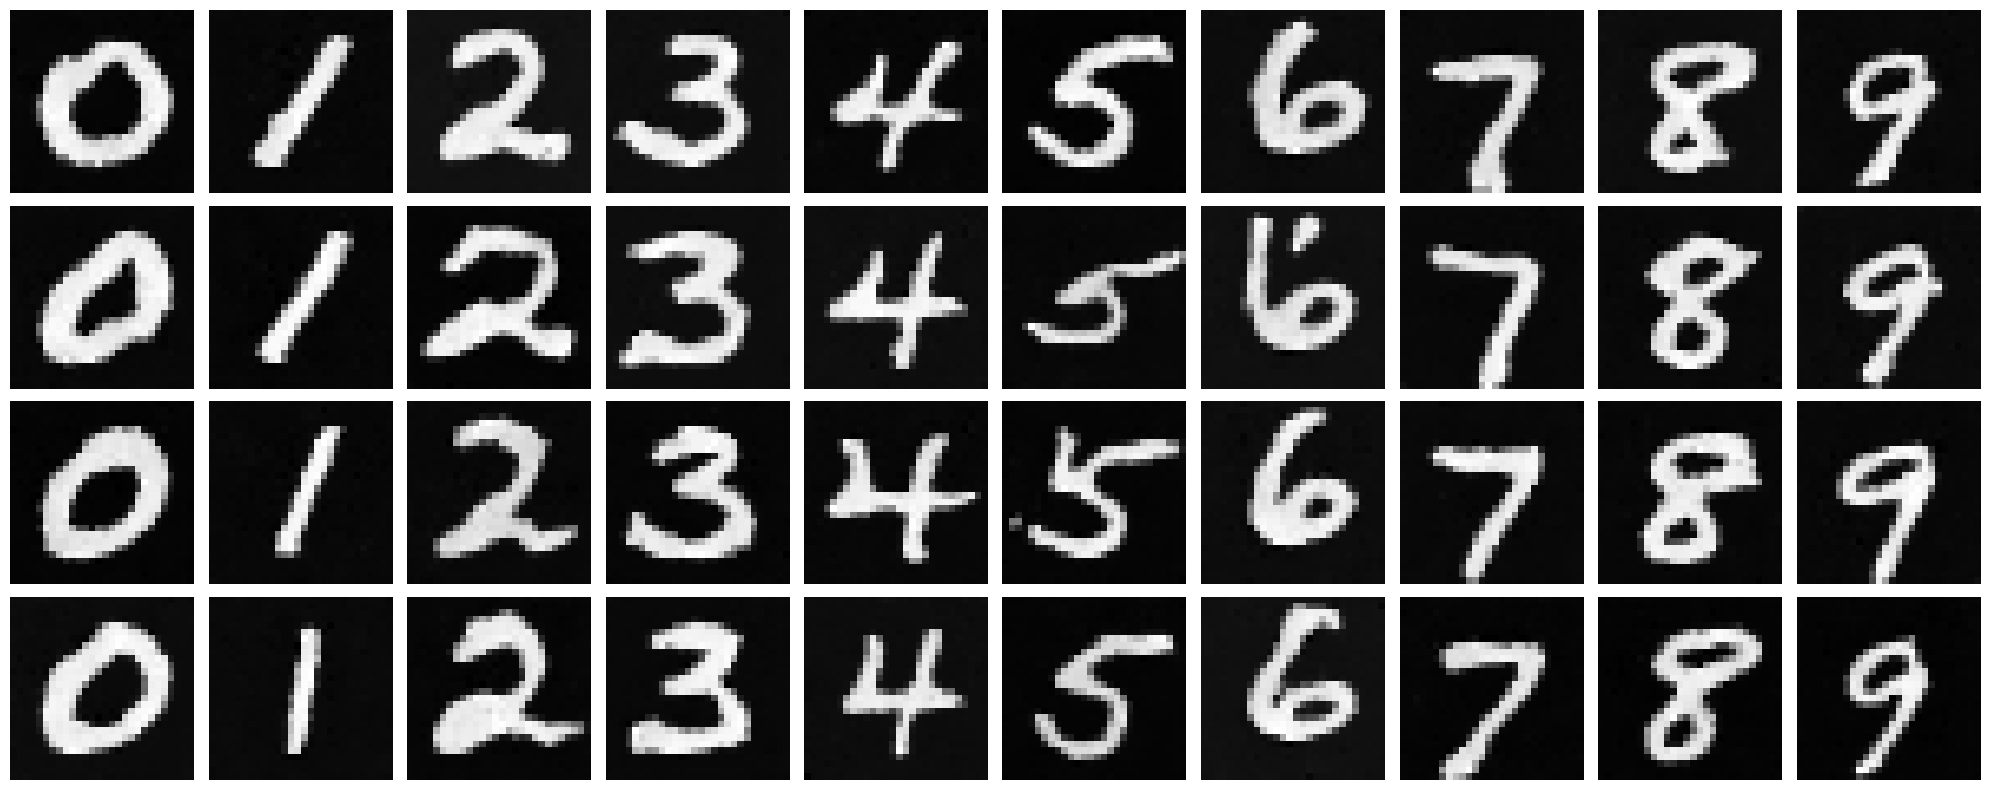

In [ ]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
  samples = class_flow_matching_model.sample(torch.from_numpy(np.arange(10)), (28,28), num_samples=10)
  samples_cpu = samples.detach().cpu().numpy()
  for j in range(10):
      axes[i, j].imshow(samples_cpu[j].reshape(28,28), cmap="grey")
      axes[i, j].axis('off')


plt.tight_layout()
plt.show()

Draw Samples From 10th Epoch

In [ ]:
class_flow_matching_model.load_state_dict(torch.load("ClassCondFlowMatching/model_20250317_232224/Epoch_10/weights", weights_only=True))

<All keys matched successfully>

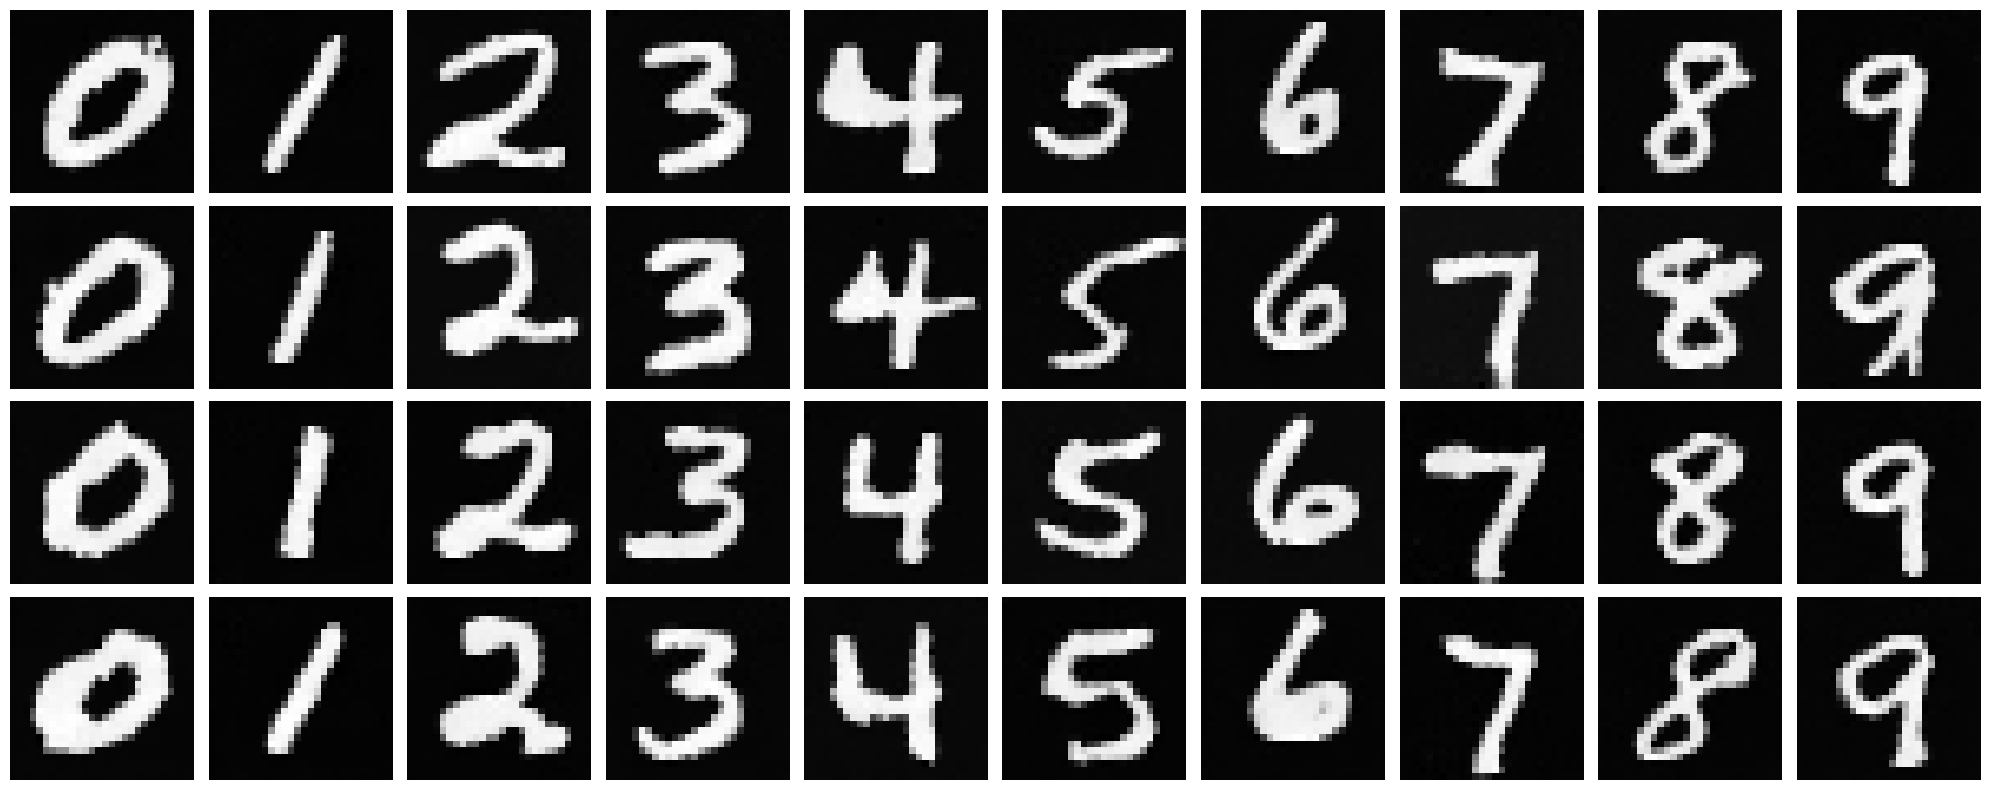

In [ ]:
fig, axes = plt.subplots(4, 10, figsize=(20, 8))

for i in range(4):
  samples = class_flow_matching_model.sample(torch.from_numpy(np.arange(10)), (28,28), num_samples=10)
  samples_cpu = samples.detach().cpu().numpy()
  for j in range(10):
      axes[i, j].imshow(samples_cpu[j].reshape(28,28), cmap="grey")
      axes[i, j].axis('off')


plt.tight_layout()
plt.show()